In [1]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from cython import *
from sympy import lambdify
import copy
from functools import *

# Parameters

In [3]:
N = [7,7]
Ec = [0.2,0.2]
Ej = [19,22]
Eu = 0.01
gamma_m = 0
needed_Ej =0
evecs = []

In [40]:
tlist_t = 250
timesteps = 3000
tlist = np.linspace(0,tlist_t,timesteps)

# Pulse

In [8]:

a = 10
b = 190
st = 3

time_coeff = "(1-(Ej-nEj)/Ej*0.5*(tanh((t-a)/st) - tanh((t-b)/st)))"
args = {'nEj':needed_Ej, 'a':a, 'b':b,'st':st, 'Ej':Ej[0]}



/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


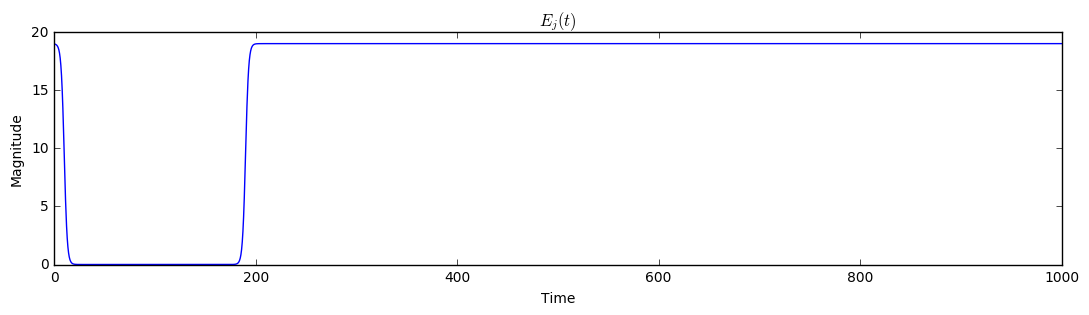

In [9]:
time_c_func = lambdify({'a','b','t','st','nEj','Ej'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(13,3))
ax.set_title('$E_j(t)$');
ax.plot(tlist, time_c_func(a=args['a'],b=args['b'],st=st,nEj=needed_Ej,Ej=Ej[0],t=tlist)*Ej[0])
#ax.set_ylim(-1.2,1.2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

# Operators

In [10]:
def n(N_states):
    return num(2*N_states+1, offset = -N_states)

def I(N_states):
    return identity(2*N_states+1)

def Hc(N_states = N[0], Ec = Ec[0], n_g = 0):
    return 4*Ec*(n(N_states)-n_g)**2

def Hj(N_states = N[0], Ej = Ej[0]):
    return -0.5*Ej*Qobj(np.diag(np.ones(2*N_states), -1)+np.diag(np.ones(2*N_states), 1))

def Hq(N_states = N[0], Ej = Ej[0], Ec = Ec[0]):
    return Hc(N_states,Ec) + Hj(N_states,Ej)

def c(N_states=N,evecs=evecs, Ej = Ej, Ec = Ec):
    return sum([n(N).matrix_element(evecs[j], evecs[j+1])/n(N).matrix_element(evecs[0], evecs[1])\
                    * evecs[j]*evecs[j+1].dag() for j in range(0, len(evecs)-1)])

def collapse_list(N_states = N,gamma_m = gamma_m):
    collapse_list = []
    if(gamma_m > 0):
        collapse_list.append(np.sqrt(gamma_m) * c())
    return collapse_list

def S_basis(evecs):
    S = [[el[0] for el in evec.data.toarray()] for evec in evecs ]
    return Qobj(S)
def convert_2toN(A2d,evecs):
    B2d = A2d.data.toarray()
    A = np.zeros(shape=(len(evecs),len(evecs)),dtype=np.complex128)
    A[0][0] = B2d[0][0]
    A[0][1] = B2d[0][1]
    A[1][0] = B2d[1][0]
    A[1][1] = B2d[1][1]
    Aq = Qobj(A)
    return Aq.transform(evecs,True)

def Hq_evecs(N_states = N[0], Ej = Ej[0], Ec = Ec[0]):
    return Hq(N_states,Ej,Ec).eigenstates()[1]
def Hq_evals(N_states = N[0], Ej = Ej[0], Ec = Ec[0]):
    return Hq(N_states,Ej,Ec).eigenstates()[0]
def Hqq_evecs(qubit):
    return Hq_evecs(N[qubit-1], Ej[qubit-1], Ec[qubit-1])
def Hqq_evals(qubit):
    return Hq_evals(N[qubit-1], Ej[qubit-1], Ec[qubit-1])
def Hqq(qubit):
    return Hq(N[qubit-1], Ej[qubit-1], Ec[qubit-1])

In [91]:
evecs = [Hqq_evecs(1),Hqq_evecs(2)]
evals = [Hqq_evals(1),Hqq_evals(2)]
w10 = [evals[0][1] - evals[0][0], evals[1][1] - evals[1][0]]
w21 = [evals[0][2] - evals[0][1], evals[1][2] - evals[1][1]]
print(w10)
print(w21)
#args['w'] = w10

[7.0617644780096356, 5.9463797191578749]
[6.715161329927156, 5.6808099794046569]


# Set needed_Ej for gate

### CZ

In [12]:
Ej_space = np.linspace(20.418181818181818*0.999,20.418181818181818*1.00, 1000)

difs = []
levels = []
for Ej_id, E_j in enumerate(Ej_space):
    evals, evecs = Hq(N[0],E_j,Ec[0]).eigenstates()
    levels.append(evals-evals[0])
    difs.append(abs(evals[1] - evals[0] - w21[1]))
m = min(difs)
needed_Ej = 0
for d_id, d in enumerate(difs):
    if d == m:
        needed_Ej = (Ej_space[d_id])
        print(m)
print(needed_Ej)        
evals, evecs = Hq(N[0], needed_Ej, Ec[0]).eigenstates()
dE = evals[0]
for i,e in enumerate(evals):
    evals[i] -= dE
evals2 = Hqq_evals(2)
dE = evals2[0]
for i,e in enumerate(evals2):
    evals2[i] -= dE
print(evals[0:3])
print(evals2[0:3])

9.5089693275e-07
20.4179365547
[  0.           5.50794378  10.79725907]
[  0.           5.72558224  11.23352697]


### iSwap

In [103]:

Ec = [0.31,0.24]
Ej = [22,20]
args['Ej']=Ej[0]
Ej_space = np.linspace(15.87289,15.8729, 1000)

difs = []
for Ej_id, E_j in enumerate(Ej_space):
    evals, evecs = Hq(N[0],E_j,Ec[0]).eigenstates()
    difs.append(abs(evals[1] - evals[0] - w10[1]))
m = min(difs)
needed_Ej = 0
for d_id, d in enumerate(difs):
    if d == m:
        needed_Ej = (Ej_space[d_id])
        print(m)
print(needed_Ej)        
evals, evecs = Hq(N[0], needed_Ej, Ec[0]).eigenstates()
dE = evals[0]
for i,e in enumerate(evals):
    evals[i] -= dE
evals2 = Hqq_evals(2)
dE = evals2[0]
for i,e in enumerate(evals2):
    evals2[i] -= dE
print(evals[0:3])
print(evals2[0:3])

1.81898940355e-11
15.8728988488
[  0.           5.94637972  11.53727098]
[  0.           5.94637972  11.6271897 ]


# Operators in tensor basis

In [97]:
def T(oper, qubit, N = N):
    if qubit == 1:
        return tensor(oper, I(N[1]))
    else:
        return tensor(I(N[0]), oper)
def THc(qubit, N = N, Ec = Ec, n_g = 0):
    return T(Hc(N[qubit-1],Ec[qubit-1]),qubit,N)    
def THj(qubit, N = N, Ej = Ej, n_g = 0):
    return T(Hj(N[qubit-1],Ej[qubit-1]),qubit,N) 

def THq(qubit, N = N, Ej = Ej, Ec = Ec):
    return THc(qubit,N,Ec) + THj(qubit,N,Ej)
    
def THqq():
    return THq(1) + THq(2)


def THic(N = N, Eu = Eu):
    return Eu * tensor(n(N[0]),n(N[1]))

def TprojN(lvl):
    def Tprojtmp(qubit, N = N):
        evecs = Hqq_evecs(qubit-1)
        A = np.zeros(shape=(len(evecs),len(evecs)),dtype=np.complex128)
        A[lvl][lvl] = 1
        return T(Qobj(A).transform(evecs,True),qubit,N)
    return Tprojtmp

def T2N(oper, qubit, N = N):
    return T(convert_2toN(oper,Hq(N[qubit-1],Ej[qubit-1],Ec[qubit-1]).eigenstates()[1]),qubit,N)

def TSx(qubit, N = N):
    return T2N(sigmax(),qubit, N)

def TSy(qubit, N = N):
    return T2N(sigmay(),qubit, N)

def TSz(qubit, N = N):
    return T2N(sigmaz(),qubit, N)

def TSp(qubit, N = N):
    return T2N(sigmap(),qubit, N)

def TSm(qubit, N = N):
    return T2N(sigmam(),qubit, N)

In [15]:
Ej_space = np.linspace(18,24, 30)

difs = []
levels = []
for Ej_id, E_j in enumerate(Ej_space):
    THsys = THq(1,N,[E_j,Ej[1]]) + THq(2) + THic()
    evals, evecs = THsys.eigenstates()
    levels.append(evals-evals[0])

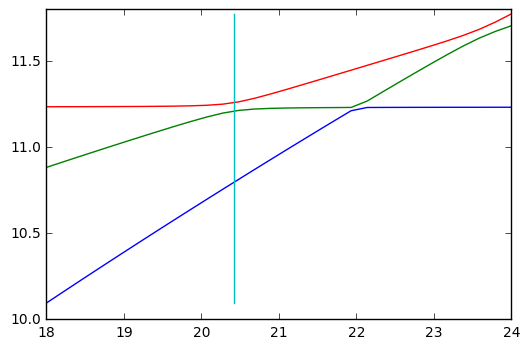

In [22]:
min_lvl = 3
max_lvl = 6
plt.plot(Ej_space, np.array(levels)[:,min_lvl:max_lvl])
plt.plot(needed_Ej*np.ones(2), [np.array(levels)[0,min_lvl], np.array(levels)[-1,max_lvl-1]])

In [101]:
Eu = 0.01
def THq_int(N = N, Ej = Ej, Ec = Ec, Eu = Eu):
    return THqq() + THic(N,Eu)

print(Eu)
print(time_coeff)
print(args)
def THq_t(time_coeff = time_coeff, N = N, Ej = Ej, Ec = Ec, Eu = Eu):
    return [THic(N,Eu) + THc(1) + THc(2) + THj(2), [THj(1) , time_coeff]] 


0.01
(1-(Ej-nEj)/Ej*0.5*(tanh((t-a)/st) - tanh((t-b)/st)))
{'st': 3, 'nEj': 15.872898848848848, 'b': 150, 'a': 50, 'w': 0, 'Ej': 19}


In [24]:
def THq_evecs(N, Ej,Ec,Eu):
    return THq_int(N,Ej,Ec,Eu).eigenstates()[1]
def THq_evals(N=N, Ej=Ej,Ec=Ec,Eu=Eu):
    return THq_int(N,Ej,Ec,Eu).eigenstates()[0]

# Visualisation

In [25]:
def Tvis_out(output):
    graphs = int(len(output.expect)/2)
    fig, axes2d = plt.subplots(graphs,2, figsize=(13,5*graphs), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    for idx, axes in enumerate(axes2d):
        for idy, ax in enumerate(axes):
            #print("%d %d"%(idx,idy))
            ax.plot(tlist, output.expect[idy*graphs + idx], label=(labels[idx]%(idy) if idx <3 else "%d(%d)"%(idx-3,idy)) + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
            ax.set_xlabel('Time')
    #axes[0].set_ylabel('Occupation probability')

# Dynamics 

In [119]:
expected = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2)]
ev1 = Hqq_evecs(1)
ev2 = Hqq_evecs(2)
#psi1 = (ev1[0]+ev1[1]) / (2**0.5)
#psi2 = (ev2[0]+ev2[1]) / (2**0.5)

#psi1 = ev1[0]
#psi2 = ev2[0]

psi1 = ev1[1]
psi2 = ev2[1]

#Tpsi0 = tensor(psi1,psi2)
#Tpsi0 = tensor(ev1[0],ev2[0]) + tensor(ev1[1],ev2[0]) + tensor(ev1[0],ev2[1]) + tensor(ev1[1],ev2[1])
#Tpsi0 = (tensor(ev1[0],(ev2[1]+ev2[0])/ (2**0.5)) + tensor((ev1[1]+ev1[0])/ (2**0.5),ev2[0]))

##CZ gate
#THsys = THq(1) + THq(2) + THic()
#Tpsi0 = THsys.eigenstates()[1][4] #~|11>


##iSwap

Tpsi0 = tensor(ev1[1],ev2[1])

def solve(expected_ops = expected,Tpsi_0 = Tpsi0, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(THq_t(), Tpsi_0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(THq_t(), Tpsi_0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

### iSwap

0.01
{'st': 3, 'nEj': 15.872898848848848, 'b': 171, 'a': 50, 'w': 0, 'Ej': 22}
10.0%. Run time:   0.69s. Est. time left: 00:00:00:06
20.0%. Run time:   1.30s. Est. time left: 00:00:00:05
30.0%. Run time:   1.96s. Est. time left: 00:00:00:04
40.0%. Run time:   2.80s. Est. time left: 00:00:00:04
50.0%. Run time:   3.67s. Est. time left: 00:00:00:03
60.0%. Run time:   4.55s. Est. time left: 00:00:00:03
70.0%. Run time:   5.55s. Est. time left: 00:00:00:02
80.0%. Run time:   6.48s. Est. time left: 00:00:00:01
90.0%. Run time:   7.53s. Est. time left: 00:00:00:00
Total run time:   8.48s


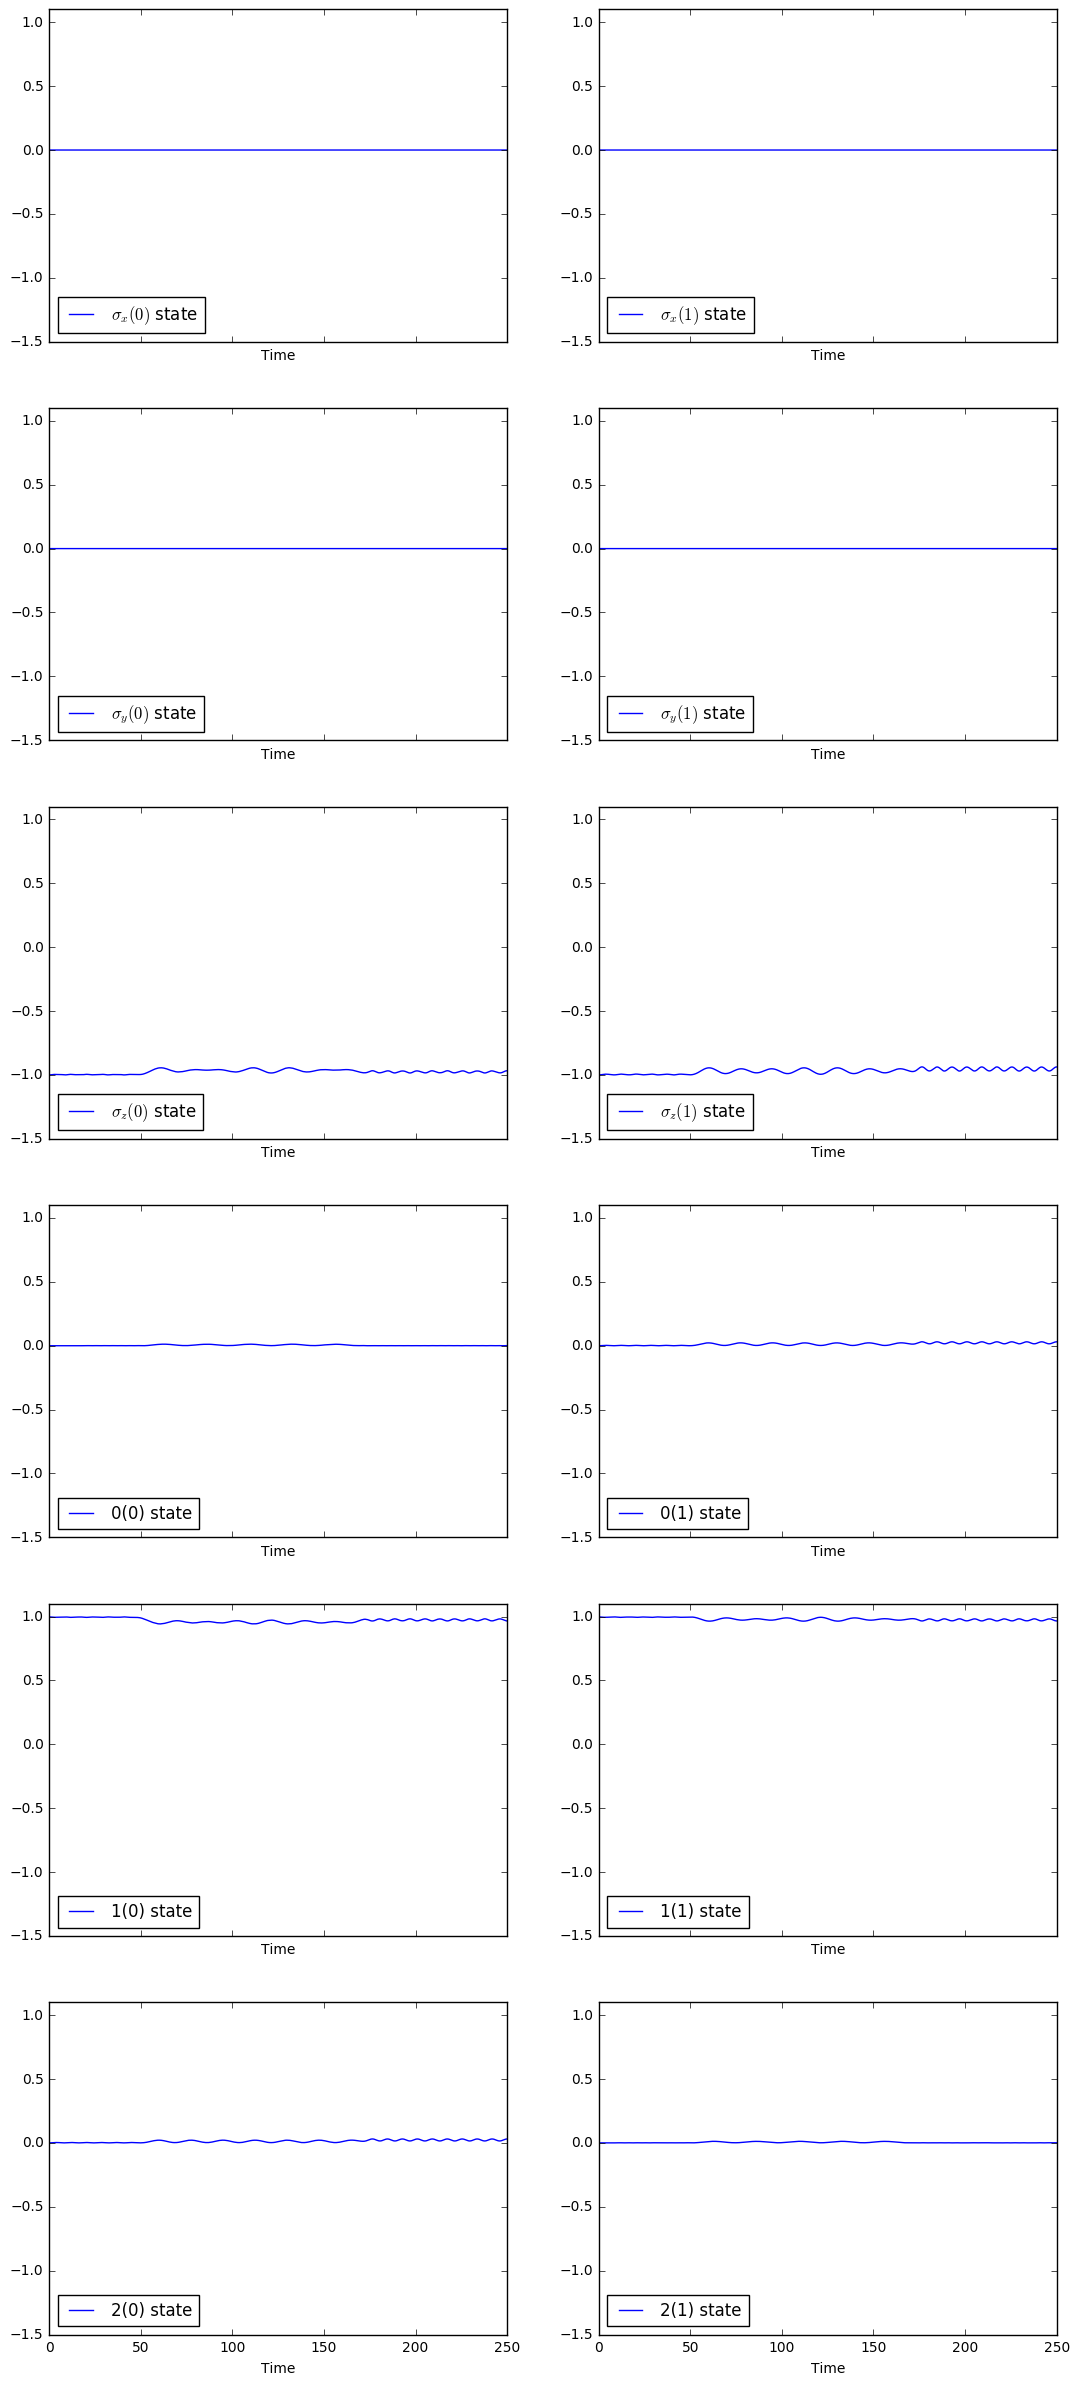

In [120]:

print(Eu)
args['a']=50
args['b']=args['a'] + 121
args['nEj'] = needed_Ej
args['w'] = 0
print(args)
#TprojN(0)(1), TprojN(1)(1), TprojN(2)(1), TprojN(3)(1), TprojN(4)(1), TprojN(5)(1), TprojN(6)(1)
#TprojN(0)(2), TprojN(1)(2), TprojN(2)(2), TprojN(3)(2), TprojN(4)(2), TprojN(5)(2), TprojN(6)(2) 
#ev1,ev2 = Hq_evecs(N[0],needed_Ej,Ec[0]), Hqq_evecs(2)

#Tpsi0 = Tpsi11
expected = [TSx(1),TSy(1),TSz(1),TprojN(0)(1), TprojN(1)(1), TprojN(2)(1),TSx(2),TSy(2),TSz(2),TprojN(0)(2), TprojN(1)(2), TprojN(2)(2)]
out = solve(expected,Tpsi0)
Tvis_out(out)

### CZ

0.01
{'st': 3, 'nEj': 20.407727586459185, 'b': 179.33616910211248, 'a': 50, 'w': 0, 'Ej': 19}
10.0%. Run time:   0.71s. Est. time left: 00:00:00:06
20.0%. Run time:   1.45s. Est. time left: 00:00:00:05
30.0%. Run time:   2.26s. Est. time left: 00:00:00:05
40.0%. Run time:   3.02s. Est. time left: 00:00:00:04
50.0%. Run time:   3.77s. Est. time left: 00:00:00:03
60.0%. Run time:   4.54s. Est. time left: 00:00:00:03
70.0%. Run time:   5.33s. Est. time left: 00:00:00:02
80.0%. Run time:   6.11s. Est. time left: 00:00:00:01
90.0%. Run time:   6.88s. Est. time left: 00:00:00:00
Total run time:   7.65s


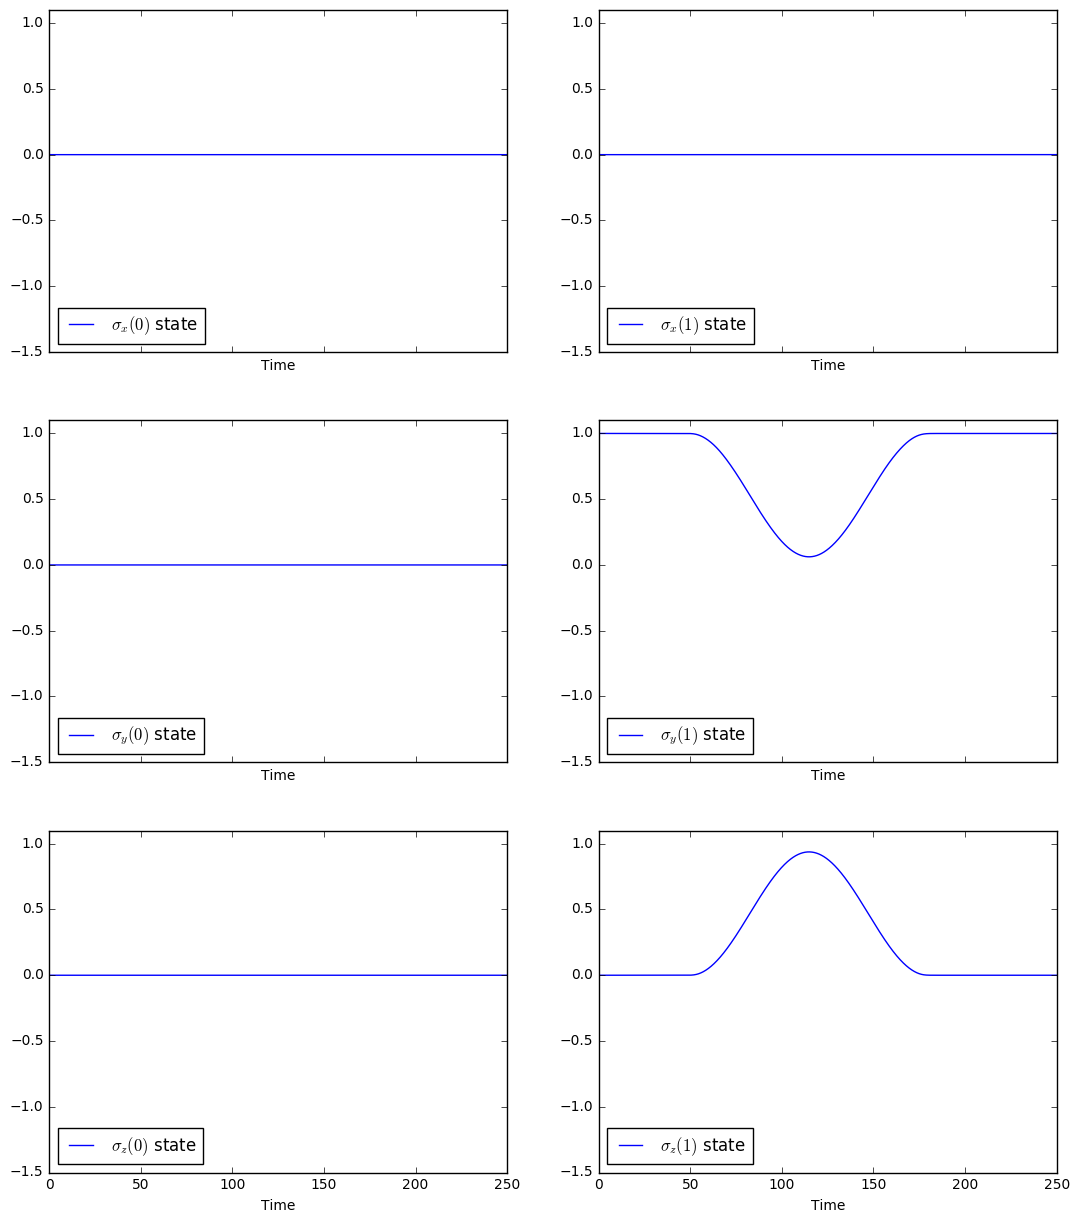

In [62]:

print(Eu)
args['a']=50
args['b']=args['a'] + 1/(E[5]-E[4])*2*np.pi
args['nEj'] = needed_Ej*0.9995
args['w'] = 0
print(args)
#TprojN(0)(1), TprojN(1)(1), TprojN(2)(1), TprojN(3)(1), TprojN(4)(1), TprojN(5)(1), TprojN(6)(1)
#TprojN(0)(2), TprojN(1)(2), TprojN(2)(2), TprojN(3)(2), TprojN(4)(2), TprojN(5)(2), TprojN(6)(2) 
#ev1,ev2 = Hq_evecs(N[0],needed_Ej,Ec[0]), Hqq_evecs(2)
ev1,ev2 = Hqq_evecs(1), Hqq_evecs(2)
Tpsi11 = tensor(ev1[1],ev2[1])
Tpsi11P = Tpsi11*Tpsi11.dag()
Tpsi02P = tensor(ev1[0],ev2[2])
Tpsi02P = Tpsi02P*Tpsi02P.dag()
Tpsi20P = tensor(ev1[2],ev2[0])
Tpsi20P = Tpsi20P*Tpsi20P.dag()
Tpsi0P = Tpsi0*Tpsi0.dag()

#Tpsi0 = Tpsi11
#expected = [TSx(1),TSy(1),TSz(1),TprojN(0)(1), TprojN(1)(1), TprojN(2)(1),TSx(2),TSy(2),TSz(2),TprojN(0)(2), TprojN(1)(2), TprojN(2)(2)]
#expected = [Tpsi11P,Tpsi02P, Tpsi20P, Tpsi0P]
P = lambda psi: psi*psi.dag()
expected = [P(psi) for psi in THsys.eigenstates()[1][0:6]]
out = solve(expected,Tpsi0)
Tvis_out(out)


In [113]:
def get_pulse_operator_Nd(ev1,ev2):
    Tpsi = [tensor(ev1[0],ev1[0]),tensor(ev1[0],ev1[1]),tensor(ev1[1],ev1[0]),tensor(ev1[1],ev1[1])]
    #Tpsi = THsys.eigenstates()[1][0:4]
    result = []
    for psi_id, Tpsi0 in enumerate(Tpsi):
        out = solve([],Tpsi0)
        state_final = out.states[-1]
        res_state = []
        #print(state_final)
        for Tpsi1 in Tpsi:
            res_state.append((Tpsi1.dag()*state_final).data.toarray()[0][0])
        result.append(res_state)
    print(result)
    return Qobj(result)

In [114]:
iop = get_pulse_operator_Nd(Hqq_evecs(1),Hqq_evecs(2))
iop

10.0%. Run time:   0.70s. Est. time left: 00:00:00:06
20.0%. Run time:   1.42s. Est. time left: 00:00:00:05
30.0%. Run time:   2.08s. Est. time left: 00:00:00:04
40.0%. Run time:   2.72s. Est. time left: 00:00:00:04
50.0%. Run time:   3.37s. Est. time left: 00:00:00:03
60.0%. Run time:   4.02s. Est. time left: 00:00:00:02
70.0%. Run time:   4.68s. Est. time left: 00:00:00:02
80.0%. Run time:   5.43s. Est. time left: 00:00:00:01
90.0%. Run time:   6.22s. Est. time left: 00:00:00:00
Total run time:   7.00s
10.0%. Run time:   0.69s. Est. time left: 00:00:00:06
20.0%. Run time:   1.41s. Est. time left: 00:00:00:05
30.0%. Run time:   2.19s. Est. time left: 00:00:00:05
40.0%. Run time:   3.02s. Est. time left: 00:00:00:04
50.0%. Run time:   3.77s. Est. time left: 00:00:00:03
60.0%. Run time:   4.52s. Est. time left: 00:00:00:03
70.0%. Run time:   5.25s. Est. time left: 00:00:00:02
80.0%. Run time:   6.00s. Est. time left: 00:00:00:01
90.0%. Run time:   6.76s. Est. time left: 00:00:00:00
Tota

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[  3.69772932e-01+0.92744361j   0.00000000e+00+0.j           0.00000000e+00+0.j
   -1.98105210e-04-0.00126744j]
 [  0.00000000e+00+0.j           5.36332675e-02-0.03209966j
   -2.68659122e-01+0.95952003j   0.00000000e+00+0.j        ]
 [  0.00000000e+00+0.j          -9.33113494e-01+0.34947654j
   -2.71957716e-02+0.05302333j   0.00000000e+00+0.j        ]
 [ -5.09464644e-05-0.00132073j   0.00000000e+00+0.j           0.00000000e+00+0.j
    9.77659342e-01+0.04487168j]]

# Operator fixing..

## CZ

In [72]:
THsys_resonant = THq(1, N, [needed_Ej*0.9995, Ej[1]]) + THq(2) + THic()
E = THsys_resonant.eigenstates()[0]
alpha3 = (E[2] - E[0])*124.1
alpha2 = (E[1] - E[0])*124.1
Rz3 = (-1j * sigmaz() * alpha3 ).expm()
Rz2 = (-1j * sigmaz() * alpha2 ).expm()
#Rz3_N = convert_2toN(Rz3, Hqq_evecs(1))
#Rz2_N = convert_2toN(Rz2, Hqq_evecs(2))
op.dims = [[2,2],[2,2]]
U1 = tensor(Rz3,Rz2)*op
U1#/U1.data.toarray()[0][0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ -8.29076304e-02 -9.96557236e-01j   0.00000000e+00 +0.00000000e+00j
    0.00000000e+00 +0.00000000e+00j  -1.74714029e-10 -8.07407978e-11j]
 [  0.00000000e+00 +0.00000000e+00j   9.98287503e-01 +1.77820448e-02j
    6.69735048e-03 +5.53263620e-02j   0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j  -4.08433246e-02 +3.79204733e-02j
    7.73733243e-01 +6.31055251e-01j   0.00000000e+00 +0.00000000e+00j]
 [  1.09420914e-10 -6.20485234e-10j   0.00000000e+00 +0.00000000e+00j
    0.00000000e+00 +0.00000000e+00j  -2.47468513e-01 -9.68767907e-01j]]

In [61]:
1/(E[5]-E[4])*2*np.pi

129.33616910211248

In [89]:
z3 = (op.data.toarray()[1][1]/op.data.toarray()[0][0])**0.5
Zz3 = Qobj([[z3,0], [0,z3.conjugate()]])

z2 = (op.data.toarray()[2][2]/op.data.toarray()[0][0])**0.5
Zz2 = Qobj([[z2,0], [0,z2.conjugate()]])

U1 = tensor(Zz2,Zz3)*op
U1 = U1/U1.data.toarray()[0][0]
U1

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[  1.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
    0.00000000e+00 +0.00000000e+00j   9.49479524e-11 -1.67418502e-10j]
 [  0.00000000e+00 +0.00000000e+00j   9.98445862e-01 +0.00000000e+00j
    7.68163545e-03 +5.51983090e-02j   0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j  -7.68386707e-03 +5.52005222e-02j
    9.98445722e-01 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j]
 [ -5.16267831e-10 +3.61168089e-10j   0.00000000e+00 +0.00000000e+00j
    0.00000000e+00 +0.00000000e+00j  -5.10383785e-01 +8.59802486e-01j]]

## iSwap

In [123]:
iop.dims = [[2,2],[2,2]]

In [116]:
iop = iop/iop.data.toarray()[0][0]
iop

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000 +0.00000000e+00j  0.00000000 +0.00000000e+00j
   0.00000000 +0.00000000e+00j -0.00125264 -2.85824622e-04j]
 [ 0.00000000 +0.00000000e+00j -0.00996956 -6.18040167e-02j
   0.79302919 +6.05858773e-01j  0.00000000 +0.00000000e+00j]
 [ 0.00000000 +0.00000000e+00j -0.02098572 +9.97746416e-01j
   0.03924218 +4.49692753e-02j  0.00000000 +0.00000000e+00j]
 [-0.00124762 -4.42497466e-04j  0.00000000 +0.00000000e+00j
   0.00000000 +0.00000000e+00j  0.40438812 -8.92914188e-01j]]

In [136]:
i3 = (iop.data.toarray()[2][1]/iop.data.toarray()[0][0])**0.5
Zi3 = Qobj([[i3,0], [0,i3.conjugate()]])
i2 = (iop.data.toarray()[1][2]/iop.data.toarray()[0][0])**0.5
Zi2 = Qobj([[i2,0], [0,i2.conjugate()]])
iop_final = tensor(Zi3,Zi2)*iop
iop_final = iop_final/ iop_final.data.toarray()[0][0]
iop_final

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[  1.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
   -1.25263747e-03-0.00028582j]
 [  0.00000000e+00+0.j          -4.54425406e-02-0.04305931j
    9.97978030e-01+0.j           0.00000000e+00+0.j        ]
 [  0.00000000e+00+0.j           9.97967089e-01+0.j
    4.41341286e-02-0.04017914j   0.00000000e+00+0.j        ]
 [  4.32198597e-04+0.00125123j   0.00000000e+00+0.j           0.00000000e+00+0.j
   -9.50187274e-01+0.24076886j]]

In [3]:
def observe(output, operators, rotationFreq, every = 1 ):
    output2 = copy.deepcopy(output)
    output2.expect = []
    for i in range(len(operators)*2):
        output2.expect.append([])
    num_operators = len(operators)
    for time, state in zip(tlist[::every], output.states[::every]):
        for i, op in enumerate(operators):
            for qubit in [1,2]:
                if rotationFreq[qubit-1] != 0:
                    U = (-convert_2toN(sigmaz(), Hq_evecs())*1j*rotationFreq[qubit-1]/2 * time).expm()
                    TU = T(U,qubit)
                    output2.expect[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
                else:
                    output2.expect[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return output2